# 사용한 라이브러리

In [1]:
import random
import numpy as np
from collections import deque
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomUniform
import tensorflow as tf
import matplotlib.pyplot as plt

# NN

In [2]:
class NN(tf.keras.Model):
    def __init__(self, action_size):
        super(NN, self).__init__()
        self.fc1 = Dense(24, activation = 'relu')
        self.fc2 = Dense(24, activation = 'relu')
        self.fc_out = Dense(action_size, kernel_initializer = RandomUniform(-1e-3, 1e-3))

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        q = self.fc_out(x)
        return q

# DQN

In [3]:
class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.epsilon = 1.0
        self.epsilon_decay = 0.999
        self.epsilon_min = 0.001
        self.batch_size = 64
        self.train_start = 1000

        self.memory = deque(maxlen = 2000)

        self.model = NN(self.action_size)
        self.target_model = NN(self.action_size)
        self.optimizer = Adam(learning_rate = self.learning_rate)

        self.update_target_model()

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q = self.model(state) # 리스트 형태로 반환됨
            return np.argmax(q[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        mini_batch = random.sample(self.memory, self.batch_size)
        states = np.array([sample[0][0] for sample in mini_batch])
        actions = np.array([sample[1] for sample in mini_batch])
        rewards = np.array([sample[2] for sample in mini_batch])
        next_states = np.array([sample[3][0] for sample in mini_batch])
        dones = np.array([sample[4] for sample in mini_batch])

        model_params = self.model.trainable_variables
            
        with tf.GradientTape() as tape:
            predicts = self.model(states)
            one_hot_action = tf.one_hot(actions , self.action_size)
            predicts = tf.reduce_sum(one_hot_action * predicts, axis=1)
        
            target_predicts = self.target_model(next_states)
            target_predicts = tf.stop_gradient(target_predicts)
        
            max_q = np.amax(target_predicts, axis=-1)
            targets = rewards + (1-dones) * self.discount_factor * max_q
            loss = tf.reduce_mean(tf.square(targets - predicts))
        
        grads = tape.gradient(loss, model_params)
        self.optimizer.apply_gradients(zip(grads, model_params))

# parameter 정의

In [4]:
state_size = 10
action_size = 3
index = 0 # GRU
agent = DQN(state_size, action_size)

scores, episodes = [], []
score_avg = 0

EPISODES = 40000

# GRU 모델의 출력 데이터 불러오기

In [5]:
gru_output = np.load('gru_output.npy')
gru_output.shape # 데이터 크기 확인

(1, 7804)

In [6]:
gru_output.shape[1] # 두번째 차원의 크기가 필요
print(gru_output)

[[71769.09 70623.95 69895.67 ... 70131.1  68497.76 67133.25]]


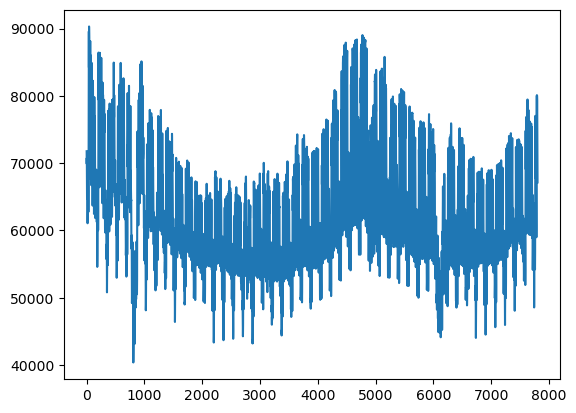

In [7]:
plt.plot(gru_output[0][:])
plt.show()

# EPISODES

In [8]:
for e in range(EPISODES):
    done = False
    score = 0
    
    state = gru_output[0][0] # 전력 수요량 데이터 한 점
    state = np.reshape(state, [1, state_size])
    
    data_length = gru_output.shape[1]
    count = 0
    index = 1
    while not done:
        action = agent.get_action(state) # 내가 행동을 결정하는 방법
        
        if action == 0:
            next_state = gru_output[0][index] - 10000 
        elif action == 1:
            next_state = gru_output[0][index]
        else:
            next_state = gru_output[0][index] + 10000
    
        next_state = np.reshape(next_state, [1, state_size]) # next_state를 [1, state_size]의 배열로 재배열 
        #print("___________________________________")
        #print(f"GRU의 출력 데이터 : {state}")
        
        # 다음 state 인덱스로 이동
        if index == data_length - 1:
            done = True  # 데이터의 끝에 도달
            
        # reward 계산 > 이 부분은 후에 구체적으로 변경 다시 해야 함
        if gru_output[0][index] == next_state:
            reward = 1
        else:
            reward = -1
        
        if count == '내가 예측할 데이터 수':
            done = True
            
        if reward < 0: #막 정한 수
            done = True  
        #print('보상 : ', reward)
        index = index + 1
        score += reward
        agent.append_sample(state, action, reward, next_state, done)

        if len(agent.memory) >= agent.train_start:
            agent.train_model()

        state = next_state

        if done:
            agent.update_target_model()
            count = count + 1
            print(f"episode : {e} | score : {score}")
            print("___________________________________")
            scores.append(score_avg)
            episodes.append(e)

ValueError: cannot reshape array of size 1 into shape (1,10)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(episodes, scores)